[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/da-python/python-for-data-analytics/blob/main/Lesson3/hometask/SyntheticRubber.ipynb)

In [103]:
## если чего-то нет
#%pip install seaborn
#%pip3 install lxml
#%pip install yfinance
#%pip install openpyxl

In [104]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; seaborn.set()
from bs4 import BeautifulSoup
import datetime
import numpy as np
import openpyxl
import os

In [105]:
# Для работы с API может потребоваться обходное решение для работы с SSL сертификатом
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


In [106]:
# Из данных есть:
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии)
customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [107]:
# Котировки натурального каучука доступны на сайте,  https://www.lgm.gov.my
# также у них есть API, пример запроса ниже

datetime.datetime.now().month
datetime.datetime.now().year

year = 2021
month = 12
url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
res = requests.get(url)
rj = res.json()
df = pd.json_normalize(rj)

,date,grade,masa,rm,us,tone
5,2021-12-30,SMR 20,Noon,726.50,177.00,Steady
12,2021-12-29,SMR 20,Noon,715.00,173.85,Quietly Steady
19,2021-12-28,SMR 20,Noon,715.00,173.80,Quietly Steady
26,2021-12-27,SMR 20,Noon,701.00,169.85,Quietly Steady
33,2021-12-24,SMR 20,Noon,704.00,170.50,Quietly Steady
40,2021-12-23,SMR 20,Noon,705.50,170.45,Quietly Steady
47,2021-12-22,SMR 20,Noon,702.00,169.55,Quietly Steady
54,2021-12-21,SMR 20,Noon,698.50,167.95,Quiet
61,2021-12-20,SMR 20,Noon,702.00,168.75,Quiet
68,2021-12-17,SMR 20,Noon,711.00,171.55,Quiet


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

### В результате должно быть 3 файла:
1. Ноутбук с расчетами и графиками.
2. Скрипт, который делает расчет цены для каждого клиента в одном файле
2. Скрипт, который делает расчет цены для каждого клиента в отельном файле

In [108]:
### Вытаскиваем цены за интересующие периоды и сливаем в один файл

year = ['2020','2021','2022']
month = ['1','2','3','4','5','6','7','8','9','10','11','12']
raw_prices = pd.DataFrame()
dfs = []

for i in year:
    for j in month:
        url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={j}&year={i}"
        res = requests.get(url)
        rj = res.json()
        df = pd.json_normalize(rj)
        #df = df[df['grade'] == 'SMR 20']
        dfs.append(df)

raw_prices = pd.concat(dfs, ignore_index=True) # объединяем выгруженные данные в один DataFrame
raw_prices['date_index'] = pd.to_datetime(raw_prices['date']) # для resample нужен индекс с использованием дат, а мы хотим
raw_prices = raw_prices.set_index(raw_prices['date_index'], drop = True) # внедряем индекс
raw_prices['us'] = raw_prices['us'].apply(lambda x:float(x)) # по умолчанию забираем object, нужен числовой формат
raw_prices['rm'] = raw_prices['rm'].apply(lambda x:float(x)) # по умолчанию забираем object, нужен числовой формат
raw_prices = raw_prices[raw_prices['grade'] == 'SMR 20'] # оставляем только нужный нам грейд
raw_prices = raw_prices.resample('M', kind = 'period').mean() # трансформируем в ежемесячные значения

In [109]:
# Запросим все возможные валютные пары на дату расчёта
# На дату расчёта, т.к. бОльшую часть издержек придётся учитывать в момент появления заказа
# Поскольку EUR - базовая валюта, все расчёты в EUR и затем переводим под клиента в нужную валюту
# Итого нужны пары: EUR/USD, EUR/CNY, EUR/RM. RM для примера, исходная котировка в малазийской валюте
# Можно забрать с помощью библиотеки YFinance

usd_eur = yf.download('USDEUR=X').resample('M', kind = 'period').mean() # Сразу трансформируем в средние ежемесячные значения - очень удобно для нашей задачи
usd_eur = usd_eur[['Close']] # интересует только цена закрытия
usd_eur.rename(columns = {'Close':'USDEUR_Close'}, inplace = True) # Поскольку дальше будем объединять, колонки нужно переназвать. Чтобы не запутаться, где какая валюта


cny_eur = yf.download('CNYEUR=X').resample('M', kind = 'period').mean()
cny_eur = cny_eur[['Close']]
cny_eur.rename(columns = {'Close':'CNYEUR_Close'}, inplace = True)


myr_eur = yf.download('MYREUR=X').resample('M', kind = 'period').mean()
myr_eur = myr_eur[['Close']]
myr_eur.rename(columns = {'Close':'MYREUR_Close'}, inplace = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [110]:
# Объединение идёт по индексам, индексы сортируются на периодам. 
# То есть чем раньше значение, тем меньше числовое значение индекса

total = pd.concat([raw_prices, usd_eur,myr_eur,cny_eur],axis = 1) 
total.dropna(inplace = True) # Пропуски убираем -- данные по сырью менее глубокие, чем данные по курсам валют
total.reset_index(inplace = True) # Ещё сбрасываем индекс - с числовым работать проще, чем с периодами

In [111]:
# lm находит для указанного поля указанного DF предыдущее значение. Соответствует логике "monthly"
def lm(df,price_column):
    for i in range(len(df[price_column])):
        if i == 0:
            pass # предыдущего значения не существует, обрабатываем ошибку
        elif i > 0:
            df.loc[i,str('lm_')+price_column] = df.loc[i-1,price_column]

# l3m находит для указанного поля указанного DF среднее из трёх предыдущих значений. Соответствует логике "moving average"
def l3m(df,price_column):
    for i in range(len(df[price_column])):
        if i <= 2:
            pass # в такой ситуации считать l3m не из чего, обрабатываем ошибку
        elif i > 2:
            df.loc[i,str('l3m_')+price_column] = np.mean([df.loc[i-1,price_column],df.loc[i-2,price_column],df.loc[i-3,price_column]])

In [112]:
# Рассчитываем средние котировки за последний месяц и за 3 последних месяца
# Нужно указать название df и следить за списком колонок с котировками

price_columns = ['rm','us','USDEUR_Close','MYREUR_Close','CNYEUR_Close'] # тот самый список-справочник

for i in price_columns:
    lm(total, i)
    l3m(total,i)

In [113]:
# Формула расчёта цены с завода
# на входе даём имя клиента из customers в кавычках и название df с финансовыми данными

def calc_FCA(name, df):
    df.dropna(inplace = True)
    df.reset_index(inplace = True,drop = True)
    quantity = customers.get(name).get('volumes')
    method = customers.get(name).get('comment')
    for i in range(len(df)):
        fca_price = 1
        total_price = 1
        if method == 'monthly':
            fca_price = quantity*df.loc[i, 'lm_rm']*df.loc[i,'lm_MYREUR_Close']+PRODUCTION_COST
            if quantity <= 100:
                total_price = (1 - discounts.get('up to 100'))*fca_price
            elif (quantity > 100) and (quantity <= 300):
                total_price = (1 - discounts.get('up to 300'))*fca_price
            else:
                total_price = (1 - discounts.get('300 plus'))*fca_price
        elif method == 'moving_average':
            fca_price = quantity*df.loc[i, 'l3m_rm']*df.loc[i,'l3m_MYREUR_Close']+PRODUCTION_COST
            if quantity <= 100:
                total_price = (1 - discounts.get('up to 100'))*fca_price
            elif (quantity > 100) and (quantity <= 300):
                total_price = (1 - discounts.get('up to 300'))*fca_price
            else:
                total_price = (1 - discounts.get('300 plus'))*fca_price

        df.loc[i,'FCA_price_'+name] = total_price
    

In [114]:
# Сугубо для иллюстрации: цена FCA по спотовым ценам

def calc_spot_FCA(name, df):
    df.dropna(inplace = True)
    df.reset_index(inplace = True,drop = True)
    quantity = customers.get(name).get('volumes')
    for i in range(len(df)):
        fca_price = 1
        total_price = 1
        fca_price = quantity*df.loc[i, 'rm']*df.loc[i,'MYREUR_Close']+PRODUCTION_COST
        if quantity <= 100:
            total_price = (1 - discounts.get('up to 100'))*fca_price
        elif (quantity > 100) and (quantity <= 300):
            total_price = (1 - discounts.get('up to 300'))*fca_price
        else:
            total_price = (1 - discounts.get('300 plus'))*fca_price

        df.loc[i,'FCA_spot_price_'+name] = total_price

In [115]:
# Формула расчёта цены с доставкой

def calc_DDP(name, df):
    df.dropna(inplace = True)
    df.reset_index(inplace = True,drop = True)
    quantity = customers.get(name).get('volumes')
    location = customers.get(name).get('location')
    method = customers.get(name).get('comment')
    for i in range(len(df)):
        total_price = 1
        ddp_price = 1
        fca_price = 1
        if method == 'monthly':
            fca_price = quantity*df.loc[i, 'lm_rm']*df.loc[i,'lm_MYREUR_Close']+PRODUCTION_COST
            if location == 'CN':
                ddp_price = fca_price + CN_LOGISTIC_COST_USD * df.loc[i, 'lm_USDEUR_Close']
                if quantity <= 100:
                    total_price = (1 - discounts.get('up to 100')) * ddp_price
                elif (quantity > 100) and (quantity <= 300):
                    total_price = (1 - discounts.get('up to 300')) * ddp_price
                else:
                    total_price = (1- discounts.get('300 plus')) * ddp_price
            elif location == 'EU':
                ddp_price = fca_price + EU_LOGISTIC_COST_EUR
                if quantity <= 100:
                    total_price = (1 - discounts.get('up to 100')) * ddp_price
                elif (quantity > 100) and (quantity <= 300):
                    total_price = (1 - discounts.get('up to 300')) * ddp_price
                else:
                    total_price = (1- discounts.get('300 plus')) * ddp_price    
        elif method == 'moving_average':
            fca_price = (quantity*df.loc[i, 'l3m_rm']*df.loc[i,'l3m_MYREUR_Close']+PRODUCTION_COST)
            if location == 'CN':
                ddp_price = fca_price + CN_LOGISTIC_COST_USD * df.loc[i, 'l3m_USDEUR_Close']
                if quantity <= 100:
                    total_price = (1 - discounts.get('up to 100')) * ddp_price
                elif (quantity > 100) and (quantity <= 300):
                    total_price = (1 - discounts.get('up to 300')) * ddp_price
                else:
                    total_price = (1- discounts.get('300 plus')) * ddp_price
            elif location == 'EU':
                ddp_price = fca_price + EU_LOGISTIC_COST_EUR
                if quantity <= 100:
                    total_price = (1 - discounts.get('up to 100')) * ddp_price
                elif (quantity > 100) and (quantity <= 300):
                    total_price = (1 - discounts.get('up to 300')) * ddp_price
                else:
                    total_price = (1- discounts.get('300 plus')) * ddp_price

        df.loc[i, 'DDP_price_'+name] = total_price

In [116]:
# Формула расчёта цены с доставкой по спотовой котировке. Для иллюстрации

def calc_spot_DDP(name, df):
    df.dropna(inplace = True)
    df.reset_index(inplace = True,drop = True)
    quantity = customers.get(name).get('volumes')
    location = customers.get(name).get('location')
    for i in range(len(df)):
        total_price = 1
        ddp_price = 1
        fca_price = 1
        fca_price = quantity*df.loc[i, 'rm']*df.loc[i,'MYREUR_Close']+PRODUCTION_COST
        if location == 'CN':
            ddp_price = fca_price + CN_LOGISTIC_COST_USD * df.loc[i, 'USDEUR_Close']
            if quantity <= 100:
                total_price = (1 - discounts.get('up to 100')) * ddp_price
            elif (quantity > 100) and (quantity <= 300):
                total_price = (1 - discounts.get('up to 300')) * ddp_price
            else:
                total_price = (1- discounts.get('300 plus')) * ddp_price
        elif location == 'EU':
            ddp_price = fca_price + EU_LOGISTIC_COST_EUR
            if quantity <= 100:
                total_price = (1 - discounts.get('up to 100')) * ddp_price
            elif (quantity > 100) and (quantity <= 300):
                total_price = (1 - discounts.get('up to 300')) * ddp_price
            else:
                total_price = (1- discounts.get('300 plus')) * ddp_price    
        df.loc[i, 'DDP_spot_price_'+name] = total_price

In [117]:
for i in customers.keys():
    calc_FCA(i, total)
    calc_spot_FCA(i,total)
    calc_DDP(i, total)
    calc_spot_DDP(i, total)

In [118]:
total_monty = total[['index','FCA_price_Monty','FCA_spot_price_Monty','DDP_price_Monty','DDP_spot_price_Monty']]
total_monty['FCA_diff'] = total_monty['FCA_spot_price_Monty'] - total_monty['FCA_price_Monty']
total_monty['DDP_diff'] = total_monty['DDP_spot_price_Monty'] - total_monty['DDP_price_Monty']
total_monty
print('При внедрении формулы для FCA за период удастся сэкономить: '+str(round(np.sum(total_monty['FCA_diff']),0))+' EUR')
print('При внедрении формулы для DDP за период удастся сэкономить: '+str(round(np.sum(total_monty['DDP_diff']),0))+' EUR')

При внедрении формулы для FCA за период удастся сэкономить: 13741.0 у.е.
При внедрении формулы для DDP за период удастся сэкономить: 13741.0 у.е.


C:\Users\mikha\AppData\Local\Temp\ipykernel_7644\3814905514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_monty['FCA_diff'] = total_monty['FCA_spot_price_Monty'] - total_monty['FCA_price_Monty']
C:\Users\mikha\AppData\Local\Temp\ipykernel_7644\3814905514.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_monty['DDP_diff'] = total_monty['DDP_spot_price_Monty'] - total_monty['DDP_price_Monty']


In [119]:
total_Triangle = total[['index','FCA_price_Triangle','FCA_spot_price_Triangle','DDP_price_Triangle','DDP_spot_price_Triangle']]
total_Triangle['FCA_diff'] = total_Triangle['FCA_spot_price_Triangle'] - total_Triangle['FCA_price_Triangle']
total_Triangle['DDP_diff'] = total_Triangle['DDP_spot_price_Triangle'] - total_Triangle['DDP_price_Triangle']

print('При внедрении формулы для FCA за период удастся сэкономить: '+str(round(np.sum(total_Triangle['FCA_diff']),0))+' EUR')
print('При внедрении формулы для DDP за период удастся сэкономить: '+str(round(np.sum(total_Triangle['DDP_diff']),0))+' EUR')

При внедрении формулы для FCA за период удастся сэкономить: 1333.0 у.е.
При внедрении формулы для DDP за период удастся сэкономить: 1342.0 у.е.


C:\Users\mikha\AppData\Local\Temp\ipykernel_7644\2926938833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_Triangle['FCA_diff'] = total_Triangle['FCA_spot_price_Triangle'] - total_Triangle['FCA_price_Triangle']
C:\Users\mikha\AppData\Local\Temp\ipykernel_7644\2926938833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_Triangle['DDP_diff'] = total_Triangle['DDP_spot_price_Triangle'] - total_Triangle['DDP_price_Triangle']


In [120]:
total_Stone = total[['index','FCA_price_Stone','FCA_spot_price_Stone','DDP_price_Stone','DDP_spot_price_Stone']]
total_Stone['FCA_diff'] = total_Stone['FCA_spot_price_Stone'] - total_Stone['FCA_price_Stone']
total_Stone['DDP_diff'] = total_Stone['DDP_spot_price_Stone'] - total_Stone['DDP_price_Stone']
print('При внедрении формулы для FCA за период удастся сэкономить: '+str(round(np.sum(total_Stone['FCA_diff']),0))+' EUR')
print('При внедрении формулы для DDP за период удастся сэкономить: '+str(round(np.sum(total_Stone['DDP_diff']),0))+' EUR')

При внедрении формулы для FCA за период удастся сэкономить: 10306.0 у.е.
При внедрении формулы для DDP за период удастся сэкономить: 10306.0 у.е.


C:\Users\mikha\AppData\Local\Temp\ipykernel_7644\3931967721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_Stone['FCA_diff'] = total_Stone['FCA_spot_price_Stone'] - total_Stone['FCA_price_Stone']
C:\Users\mikha\AppData\Local\Temp\ipykernel_7644\3931967721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_Stone['DDP_diff'] = total_Stone['DDP_spot_price_Stone'] - total_Stone['DDP_price_Stone']


In [121]:
total_Poly = total[['index','FCA_price_Poly','FCA_spot_price_Poly','DDP_price_Poly','DDP_spot_price_Poly']]
total_Poly['FCA_diff'] = total_Poly['FCA_spot_price_Poly'] - total_Poly['FCA_price_Poly']
total_Poly['DDP_diff'] = total_Poly['DDP_spot_price_Poly'] - total_Poly['DDP_price_Poly']
print('При внедрении формулы для FCA за период удастся сэкономить: '+str(round(np.sum(total_Poly['FCA_diff']),0))+' EUR')
print('При внедрении формулы для DDP за период удастся сэкономить: '+str(round(np.sum(total_Poly['DDP_diff']),0))+' EUR')

При внедрении формулы для FCA за период удастся сэкономить: 3110.0 у.е.
При внедрении формулы для DDP за период удастся сэкономить: 3110.0 у.е.


C:\Users\mikha\AppData\Local\Temp\ipykernel_7644\3129012897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_Poly['FCA_diff'] = total_Poly['FCA_spot_price_Poly'] - total_Poly['FCA_price_Poly']
C:\Users\mikha\AppData\Local\Temp\ipykernel_7644\3129012897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_Poly['DDP_diff'] = total_Poly['DDP_spot_price_Poly'] - total_Poly['DDP_price_Poly']


In [122]:
# часть про всех клиентов разом


total['FCA_for_all'] = total['FCA_price_Monty'] + total['FCA_price_Triangle'] + total['FCA_price_Stone'] + total['FCA_price_Poly']
total['FCA_spot_for_all'] = total['FCA_spot_price_Monty'] + total['FCA_spot_price_Triangle'] + total['FCA_spot_price_Stone'] + total['FCA_spot_price_Poly']
total['FCA_diff'] = total['FCA_spot_for_all'] - total['FCA_for_all']


total['DDP_for_all'] = total['DDP_price_Monty'] + total['DDP_price_Triangle'] + total['DDP_price_Stone'] + total['DDP_price_Poly']
total['DDP_spot_for_all'] = total['DDP_spot_price_Monty'] + total['DDP_spot_price_Triangle'] + total['DDP_spot_price_Stone'] + total['DDP_spot_price_Poly']
total['DDP_diff'] = total['DDP_spot_for_all'] - total['DDP_for_all']

prices_all = total[['index','FCA_for_all','FCA_spot_for_all','FCA_diff','DDP_for_all','DDP_spot_for_all','DDP_diff']]

<AxesSubplot:ylabel='FCA_for_all'>

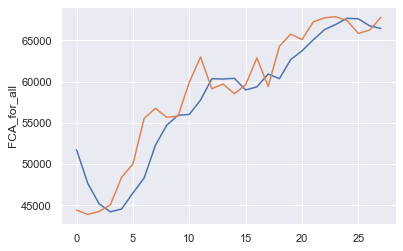

In [123]:
# по всем контрагентам
sns.lineplot(data = prices_all, x=prices_all.index, y = 'FCA_for_all')
sns.lineplot(data = prices_all, x=prices_all.index, y = 'FCA_spot_for_all')


<AxesSubplot:ylabel='FCA_price_Monty'>

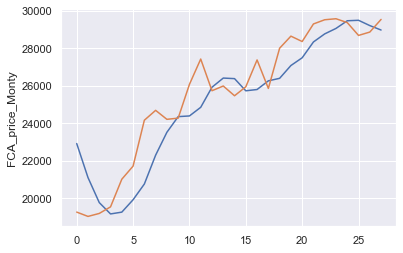

In [124]:
# по Monty
sns.lineplot(data = total_monty, x=total_monty.index, y = 'FCA_price_Monty')
sns.lineplot(data = total_monty, x=total_monty.index, y = 'FCA_spot_price_Monty')


<AxesSubplot:ylabel='FCA_price_Triangle'>

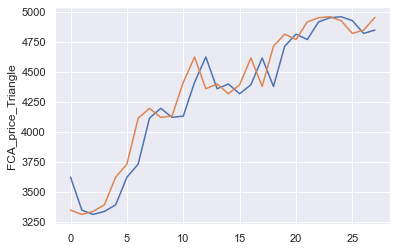

In [125]:
# по Triangle
sns.lineplot(data = total_Triangle, x=total_Triangle.index, y = 'FCA_price_Triangle')
sns.lineplot(data = total_Triangle, x=total_Triangle.index, y = 'FCA_spot_price_Triangle')


<AxesSubplot:ylabel='FCA_price_Poly'>

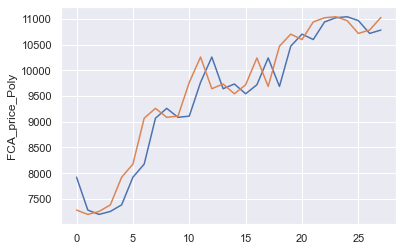

In [126]:
# по Poly
sns.lineplot(data = total_Poly, x=total_Poly.index, y = 'FCA_price_Poly')
sns.lineplot(data = total_Poly, x=total_Poly.index, y = 'FCA_spot_price_Poly')


<AxesSubplot:ylabel='FCA_price_Stone'>

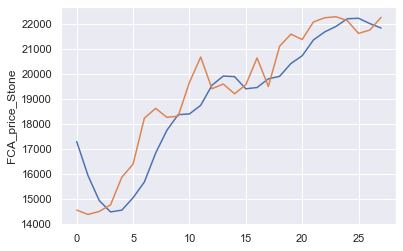

In [127]:
# по Stone
sns.lineplot(data = total_Stone, x=total_Stone.index, y = 'FCA_price_Stone')
sns.lineplot(data = total_Stone, x=total_Stone.index, y = 'FCA_spot_price_Stone')

In [129]:
# Создаём директорию и выгружаем

os.mkdir(os.path.join(os.getcwd(),'Clients'))
os.chdir(os.path.join(os.getcwd(),'Clients'))
# В один файл на разных листах
with pd.ExcelWriter('all_clients.xlsx') as writer:
    total_monty.to_excel(writer, sheet_name='Monty')
    total_Poly.to_excel(writer, sheet_name='Poly')
    total_Stone.to_excel(writer, sheet_name='Stone')
    total_Triangle.to_excel(writer, sheet_name='Triangle')
# В разные файлы
    total_monty.to_excel('Monty.xlsx', sheet_name ='Prices')
    total_Poly.to_excel('Poly.xlsx', sheet_name ='Prices')
    total_Stone.to_excel('Stone.xlsx', sheet_name ='Prices')
    total_Triangle.to_excel('Triangle.xlsx', sheet_name ='Prices')
    prices_all.to_excel('Prices for all.xlsx', sheet_name ='Prices')


# Задание 2. Продолжение

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

В результате должно быть 3 файла
1. Ноутбук с расчетами и графиками (чтобы данные подтягивались туда)
2. Скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [ ]:
# 

# Задание 3. Back to Russia

К вам пришел новый клиент из России, он готов регулярно закупать синтетический каучук. Клиент готов забирать ВБП с завода самостоятельно.
1. На основе тех данных, которые уже есть предложите цену новому клиенту. 
2. Подготовьте скрипт, который будет использовать курс публикуемый на <a href='http://www.cbr.ru/currency_base/dynamics/'> сайте ЦБ РФ</a> или из любого другого источника.


In [ ]:
## К данным по каучуку надо добавить курс RUB/EUR
## Больше ничего не меняется

rub_eur = yf.download('EURRUB=X').resample('M', kind = 'period').mean()
rub_eur = rub_eur[['Close']]
rub_eur = 1/(rub_eur)
rub_eur.rename(columns = {'Close':'RUBEUR_Close'}, inplace = True)

total_rub = pd.concat([raw_prices, rub_eur,myr_eur],axis = 1) 
total_rub.dropna(inplace = True) # Пропуски убираем -- данные по сырью менее глубокие, чем данные по курсам валют
total_rub.reset_index(inplace = True) # Ещё сбрасываем индекс - с числовым работать проще, чем с периодами

price_columns_rub = ['rm','us','RUBEUR_Close','MYREUR_Close'] # тот самый список-справочник

for i in price_columns_rub:
    lm(total_rub, i)
    l3m(total_rub,i)

[*********************100%***********************]  1 of 1 completed


In [ ]:
## Поскольку клиент не сообщил ни предпочтительный способ расчёта, ни объём заказа, 
## то оставим их входными параметрами в новой функции


def calc_FCA_RUB(method, quantity, df):
    df.dropna(inplace = True)
    df.reset_index(inplace = True,drop = True)
    for i in range(len(df)):
        fca_price = 1
        total_price = 1
        if method == 'monthly':
            fca_price = quantity*df.loc[i, 'lm_rm']*df.loc[i,'lm_MYREUR_Close']+PRODUCTION_COST
            if quantity <= 100:
                total_price = (1 - discounts.get('up to 100'))*fca_price
            elif (quantity > 100) and (quantity <= 300):
                total_price = (1 - discounts.get('up to 300'))*fca_price
            else:
                total_price = (1 - discounts.get('300 plus'))*fca_price
        elif method == 'moving_average':
            fca_price = quantity*df.loc[i, 'l3m_rm']*df.loc[i,'l3m_MYREUR_Close']+PRODUCTION_COST
            if quantity <= 100:
                total_price = (1 - discounts.get('up to 100'))*fca_price
            elif (quantity > 100) and (quantity <= 300):
                total_price = (1 - discounts.get('up to 300'))*fca_price
            else:
                total_price = (1 - discounts.get('300 plus'))*fca_price

        df.loc[i,'FCA_price_RUS'] = total_price
    
    

# Задание 4. Check it

* Подумайте, как можно проверить корректность работы алгоритма? 
* Какие возможны ошибки?
* Придумайте тесты для проверки возможных ошибок алгоритма
* Интергрируйте их в свои скрипты в виде исключений


In [ ]:
# 

# Задание 5. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ, но помните о PEP8

In [ ]:
# import yourpackage

# Задание 6. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

* Создайте отдельный пакет, который можно устанавливать с помощью pip 
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в репозиторий

In [ ]:
# !pip install yourpackage
# import yourpackage